In [1]:
import pdb
import subject_data as sd
import os
import random
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import numpy as np

import cv2

import glob

from scipy.io import loadmat

import random

from random import seed, randint

from sklearn.model_selection import train_test_split

import pandas as pd

2023-05-09 12:43:32.953325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
num_classes = 85
num_features = 100*100*40

# Training parameters. Sunday, May 24, 2020 
learning_rate = 0.001 # start with 0.001
training_steps = 50000
batch_size = 16
display_step = 50

sam = None

In [3]:
im_size = (100,100)
def get_subject_training_data(subjects, beg, tot):

    sub1_data, sub1_ppg = sd.get_sub1_data(beg, tot)
    sub2_data, sub2_ppg = sd.get_sub2_data(beg, tot)
    sub3_data, sub3_ppg = sd.get_sub3_data(beg, tot)
    sub4_data, sub4_ppg = sd.get_sub4_data(beg, tot)
    sub5_data, sub5_ppg = sd.get_sub5_data(beg, tot)
    sub6_data, sub6_ppg = sd.get_sub6_data(beg, tot)
    sub7_data, sub7_ppg = sd.get_sub7_data(beg, tot)

    frame_cons = 40 # how many frame to consider at a time
    random.seed(1)
    rv = np.arange(0, tot - frame_cons, 1)
    np.random.shuffle(rv)

    def gen_pulR(ppg):
        return np.reshape(ppg, [ppg.shape[0],1])

    rv =  np.array(rv)
    pulR1 = gen_pulR(sub1_ppg)
    pulR2 = gen_pulR(sub2_ppg)
    pulR3 = gen_pulR(sub3_ppg)
    pulR4 = gen_pulR(sub4_ppg)
    pulR5 = gen_pulR(sub5_ppg)
    pulR6 = gen_pulR(sub6_ppg)
    pulR7 = gen_pulR(sub7_ppg)

    trainX = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
    trainY = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}

    sub1_data = sub1_data[:,:,:,np.newaxis]
    sub2_data = sub2_data[:,:,:,np.newaxis]
    sub3_data = sub3_data[:,:,:,np.newaxis]
    sub4_data = sub4_data[:,:,:,np.newaxis]
    sub5_data = sub5_data[:,:,:,np.newaxis]
    sub6_data = sub6_data[:,:,:,np.newaxis]
    sub7_data = sub7_data[:,:,:,np.newaxis]

    def im_get(data, i):
        img = data[i:i+frame_cons,:,:,0]
        if img.shape[0] < frame_cons:
            return None
        img = np.reshape(img, [frame_cons, *im_size])
        img = np.moveaxis(img, 0,-1)
        return img

    for j, i in enumerate(rv):
        
        img1 = im_get(sub1_data, i)
        img2 = im_get(sub2_data, i)
        img3 = im_get(sub3_data, i)
        img4 = im_get(sub4_data, i)
        img5 = im_get(sub5_data, i)
        img6 = im_get(sub6_data, i)
        img7 = im_get(sub7_data, i)

        if img1 is None or img2 is None or img3 is None or img4 is None or img5 is None or img6 is None or img7 is None:
            continue

        trainX[1].append(img1)
        trainX[2].append(img2)
        trainX[3].append(img3)
        trainX[4].append(img4)
        trainX[5].append(img5)
        trainX[6].append(img6)
        trainX[7].append(img7)
        
        p_point = np.int(np.round(i*64/30))
        
        ppg = pulR1[p_point: p_point+85, 0]
        trainY[1].append(ppg)
        ppg = pulR2[p_point: p_point+85, 0]
        trainY[2].append(ppg)
        ppg = pulR3[p_point: p_point+85, 0]
        trainY[3].append(ppg)
        ppg = pulR4[p_point: p_point+85, 0]
        trainY[4].append(ppg)
        ppg = pulR5[p_point: p_point+85, 0]
        trainY[5].append(ppg)
        ppg = pulR6[p_point: p_point+85, 0]
        trainY[6].append(ppg)
        ppg = pulR7[p_point: p_point+85, 0]
        trainY[7].append(ppg)

    to_delete = []
    for key in trainX:
        try:
            trainX[key] = np.array(trainX[key], dtype = np.float32)
            trainX[key] = (trainX[key]-trainX[key].min())
            trainX[key] = trainX[key]/ trainX[key].max()
            
            trainY[key] = np.array(trainY[key], dtype = np.float32)
            trainY[key] = trainY[key] - trainY[key].min(axis = 1)[:, np.newaxis]
            trainY[key] = (trainY[key]/(trainY[key].max(axis = 1)[:, np.newaxis]+ 10**-5))*2-1
        except:
            print(f'Beg: {beg}, Tot: {tot}: had to delete subject {key}')
            to_delete.append(key)
    for key in to_delete:
        del trainX[key]
        del trainY[key]


    training_data = []
    testing_data = []
    trXs = []
    trYs = []
    teXs = []
    teYs = []
    for key in trainX:
        if key in subjects:

            trX, teX, trY, teY = train_test_split(trainX[key], trainY[key], 
                                                test_size = .1, random_state = 42)
            trXs.append(trX)
            trYs.append(trY)
            teXs.append(teX)
            teYs.append(teY)

            train_data = tf.data.Dataset.from_tensor_slices((trX, trY))
            train_data = train_data.repeat().shuffle(buffer_size=100,
                                                    seed= 8).batch(batch_size).prefetch(1)        
            test_data = tf.data.Dataset.from_tensor_slices((teX, teY))
            test_data = test_data.repeat().shuffle(buffer_size=100,
                                                    seed= 8).batch(batch_size).prefetch(1)

            training_data.append(train_data)
            testing_data.append(test_data)

    return training_data, testing_data, trXs, trYs, teXs, teYs


# training_data, testing_data = get_subject_training_data(100, 100)

In [4]:
def RootMeanSquareLoss(x,y):
    
    # pdb.set_trace()  
    loss = tf.keras.losses.MSE(y_true = y, y_pred =x)  # initial one
    #return tf.reduce_mean(loss)  # some other shape similarity
     
    loss2 = tf.reduce_mean((tf.math.abs(tf.math.sign(y))-tf.math.sign(tf.math.multiply(x,y))),axis = -1)
    # print(loss2.shape)
    
    # print(tf.reduce_mean(loss), tf.reduce_mean(loss2))
    return loss + 0.5*loss2

In [5]:
def run_optimization(optimizer, neural_net, x,y):    # for the second network varies in head
    with tf.GradientTape() as g:
        pred =  neural_net(x, training = True) 
        loss =  RootMeanSquareLoss(y, pred)  # change for mtl
    
        trainable_variables =  neural_net.trainable_variables
        gradients =  g.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))


train_loss = []
val_loss = []

            
def Val_loss (neural_net, testX, testY):
    pred = neural_net(testX, training = False)
    loss = RootMeanSquareLoss(testY, pred)
    val_loss.append(tf.reduce_mean(loss))
    

val_loss_chunk_size = 16

def train_personalized_network(subject, training_steps, frames_used = 3000, learning_rate = 0.0008):

    if not os.path.exists('personalized_weights'):
        os.mkdir('personalized_weights')
    if not os.path.exists(f'personalized_weights/subject_{subject}'):
        os.mkdir(f'personalized_weights/subject_{subject}')
    
    mtl_body =  MtlNetwork_body()
    head1 =  MtlNetwork_head(num_classes)
    head2 = MtlNetwork_head(num_classes)
    neural_net1 =  tf.keras.Sequential([mtl_body, head1])
    neural_net2 =  tf.keras.Sequential([mtl_body, head2])
    print('Initialized networks')

    optimizer  = tf.optimizers.Adam(learning_rate)

    train_data, test_data, trXs, trYs, teXs, teYs = get_subject_training_data([subject], 0, frames_used)
    train_data = train_data[0]
    test_data = test_data[0]
    trX = trXs[0]
    trY = trYs[0]
    teX = teXs[0]
    teY = teYs[0]
    print('Got training data')
    
    min_val_loss = float('inf')

    print('Starting training')
    for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1): 
        run_optimization(optimizer, neural_net1, batch_x, batch_y)
        
        if step % 10 == 0:
            
            pred = neural_net1(batch_x, training=True)
            loss = RootMeanSquareLoss(batch_y, pred)
            train_loss.append(tf.reduce_mean(loss))
            
            tp = np.random.randint(450)
            test_X = teX[tp + 0: tp + val_loss_chunk_size]
            test_Y = teY[tp + 0: tp + val_loss_chunk_size]
            while len(test_X) < val_loss_chunk_size:
                tp = np.random.randint(450)
                test_X = np.concatenate((test_X, teX[tp + 0: tp + val_loss_chunk_size]), axis = 0)
                test_Y = np.concatenate((test_Y, teY[tp + 0: tp + val_loss_chunk_size]), axis = 0)

            Val_loss(neural_net1, test_X, test_Y)
            current_val_loss = val_loss[-1]
            print("step: %i, loss: %f val Loss: %f" % (step, tf.reduce_mean(loss), current_val_loss))
            
            # Save the model weights if the current validation loss is lower than the previous minimum validation loss
            if current_val_loss < min_val_loss:
                
                min_val_loss = current_val_loss                
                print(f'Saving model with validation loss: {min_val_loss}\n')
                neural_net1.save_weights(f'personalized_weights/subject_{subject}/model_weights')
    
    return neural_net1, neural_net2


In [6]:
from net_work_def import  MtlNetwork_head, MtlNetwork_body
from tqdm import tqdm


with tf.device('gpu:0'):
    n1, n2 = train_personalized_network(1, 20000, frames_used = 3000)

Initialized networks


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Got training data
Starting training
step: 10, loss: 0.792501 val Loss: 0.803967
Saving model with validation loss: 0.803966760635376

step: 20, loss: 0.752462 val Loss: 0.747887
Saving model with validation loss: 0.7478874325752258

step: 30, loss: 0.759078 val Loss: 0.766695
step: 40, loss: 0.725795 val Loss: 0.760959
step: 50, loss: 0.721435 val Loss: 0.714582
Saving model with validation loss: 0.7145822048187256

step: 60, loss: 0.743580 val Loss: 0.790933
step: 70, loss: 0.730114 val Loss: 0.784839
step: 80, loss: 0.768000 val Loss: 0.748211
step: 90, loss: 0.700577 val Loss: 0.711948
Saving model with validation loss: 0.7119482755661011

step: 100, loss: 0.763246 val Loss: 0.757623
step: 110, loss: 0.754867 val Loss: 0.790884
step: 120, loss: 0.766159 val Loss: 0.813793
step: 130, loss: 0.803105 val Loss: 0.716595
step: 140, loss: 0.796327 val Loss: 0.717831
step: 150, loss: 0.779306 val Loss: 0.817168
step: 160, loss: 0.760489 val Loss: 0.760406
step: 170, loss: 0.752534 val Loss

In [7]:
sub1_data, sub1_ppg = sd.get_sub1_data(1000, 100)

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


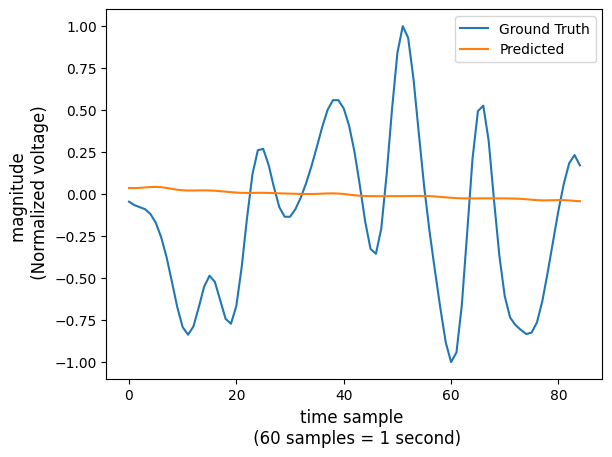

In [8]:
mtl_body =  MtlNetwork_body()
head1 =  MtlNetwork_head(num_classes)
head2 = MtlNetwork_head(num_classes)

neural_net1 =  tf.keras.Sequential([mtl_body, head1])
neural_net1.load_weights('personalized_weights/subject_1/model_weights')

i = 0
tX = np.reshape(sub1_data[i: i + 40,:,:], [40,100,100])
tX = np.array(tX, dtype= np.float64)
tX = np.moveaxis(tX, 0,-1) # very important line in axis changeing 

p_point = np.int(np.round(i*64/30))
gt = sub1_ppg[p_point: p_point+85, 0]
gt = (gt-gt.min())/(gt.max()-gt.min())

tX1 = np.reshape(tX, [-1, 100,100,40])
plt.plot(gt*2-1)
tX1 = (tX1 - tX1.min())/(tX1.max() - tX1.min())
predd = neural_net1(tX1) 
plt.plot(predd[0])

plt.legend(["Ground Truth", "Predicted"])
plt.xlabel('time sample \n (60 samples = 1 second)', fontsize =12)
plt.ylabel('magnitude \n (Normalized voltage)', fontsize = 12)
from matplotlib import rcParams
rcParams['lines.linewidth'] = 2
rcParams['lines.color'] = 'r'
plt.show()